# Imports

In [164]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load data

In [210]:
categories = {
                # "openflights": "road",
                "us_roads_AK": "road",
                "us_roads_CT": "road",
                "us_roads_NH": "road",
                "us_roads_VT": "road",
                "roadNet-CA": "road",
                "AstroPh": "collaboration",
                "CondMat": "collaboration",
                "HepPh": "collaboration",
                "TerroristRel": "collaboration",
                "marvel_universe": "collaboration",
                # "reddit-hyperlink": "social",
                "rt-retweet-crawl": "social",
                # "wikipedia_clickstream": "social",
                "digg_reply": "social",
                "email_enron": "social"
            }

label_dict = {
                "topkcloseness_0": "topk closeness BFSCUT",
                "topkcloseness_1": "topk closeness LB",
                }

In [201]:
results = {}

for key in categories.keys():
    print(key)
    
    with open(f"{key}_False.json") as f:
        json_content = json.load(f) 
        results[key] = json_content

us_roads_AK
us_roads_CT
us_roads_NH
us_roads_VT
roadNet-CA
AstroPh
CondMat
HepPh
TerroristRel
marvel_universe
rt-retweet-crawl
digg_reply
email_enron


In [202]:
markers_catalog = {
                    "road": "X", 
                    "collaboration": "o", 
                    "social": "^"
                    }

# Network statistics

## Distribution of nodes and edges

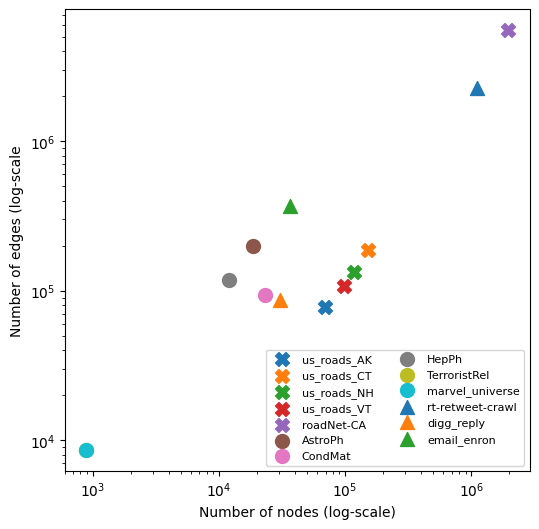

In [203]:
plt.figure(figsize=(6, 6))

scatters = []
labels = []

for dataset in results.keys():    
    s = plt.scatter(results[dataset]["nodes"], results[dataset]["edges"], marker=markers_catalog[categories[dataset]], s=100)
    scatters.append(s)
    labels.append(dataset)
    
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number of nodes (log-scale)")
plt.ylabel("Number of edges (log-scale")

plt.legend(scatters,
           labels,
           scatterpoints=1,
           ncol=2,
           loc="lower right",
           fontsize=8
          )
    
plt.show()

## Relation between diameter, average clustering coefficient and density of networks
Also plotted nodes vs edges, to fit together in the narrow columns of the paper

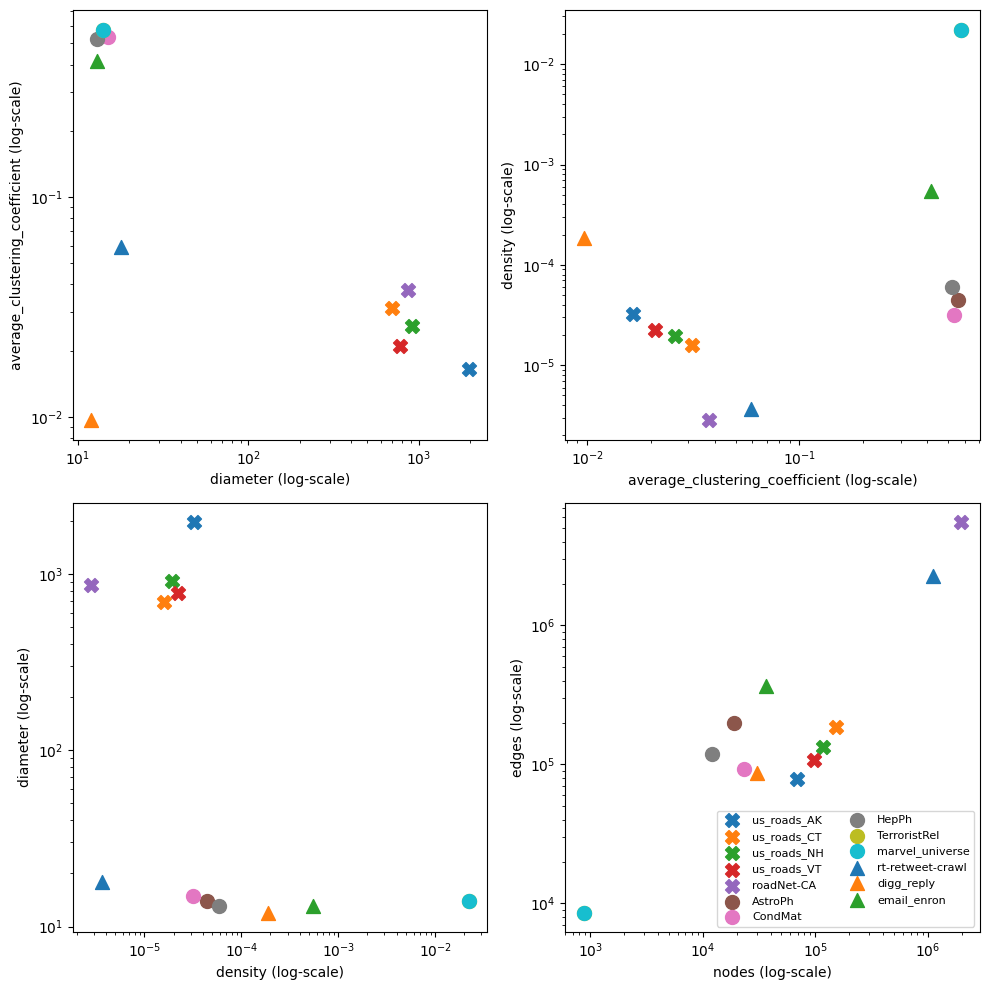

In [250]:
scatters = []
metrics1 = ["diameter", "average_clustering_coefficient", "density", "nodes"]
metrics2 = ["average_clustering_coefficient", "density", "diameter", "edges"]

fig, ax = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

for index, (metric1, metric2) in enumerate(zip(metrics1, metrics2)):        
    if metric1 == "diameter":
        metrics1_values = [results[dataset][metric1][0] for dataset in results.keys()]

    else:
        metrics1_values = [results[dataset][metric1] for dataset in results.keys()]
        
    if metric2 == "diameter":
        metrics2_values = [results[dataset][metric2][0] for dataset in results.keys()]

    else:
        metrics2_values = [results[dataset][metric2] for dataset in results.keys()]
        
    for j, dataset in enumerate(results.keys()):
        s = ax[int(index/2), index%2].scatter(metrics1_values[j], metrics2_values[j], marker=markers_catalog[categories[dataset]], s=100)

        if index == 2:
            scatters.append(s)
        
    ax[int(index/2), index%2].set_xscale("log")
    ax[int(index/2), index%2].set_yscale("log")
            
    ax[int(index/2), index%2].set_xlabel(f"{metric1} (log-scale)")
    ax[int(index/2), index%2].set_ylabel(f"{metric2} (log-scale)")
    

plt.legend(scatters,
           [dataset for dataset in results.keys()],
           scatterpoints=1,
           ncol=2,
           loc="lower right",
           fontsize=8
          )

plt.savefig("../images/metrics_relationship.png")

plt.show()

# Time ratios

## Topk closeness BFSCUT to closeness centrality computation time ratio across datasets and k

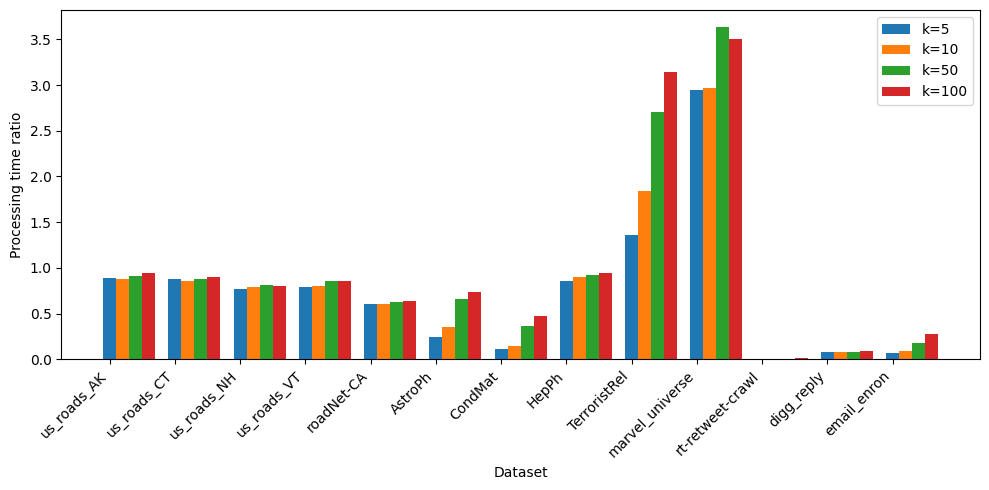

In [258]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

plt.figure(figsize=(10, 5))

for index_k, k in enumerate(ks):
    ratios = [results[dataset]["time_elapsed"]["topkcloseness_0"][str(k)]/results[dataset]["time_elapsed"]["closeness"] for dataset in results.keys()]
    plt.bar(x + (width * index_k), ratios, width, label=f"k={k}")
    
plt.xticks(x, xticklabels, rotation=45, ha="right")
plt.xlabel("Dataset")
plt.ylabel("Processing time ratio")
plt.legend()
plt.tight_layout()

plt.savefig("../images/time_ratios_bar_BFSCUT.png")
plt.show()

## Topk closeness LB to closeness centrality computation time ratio across datasets and k

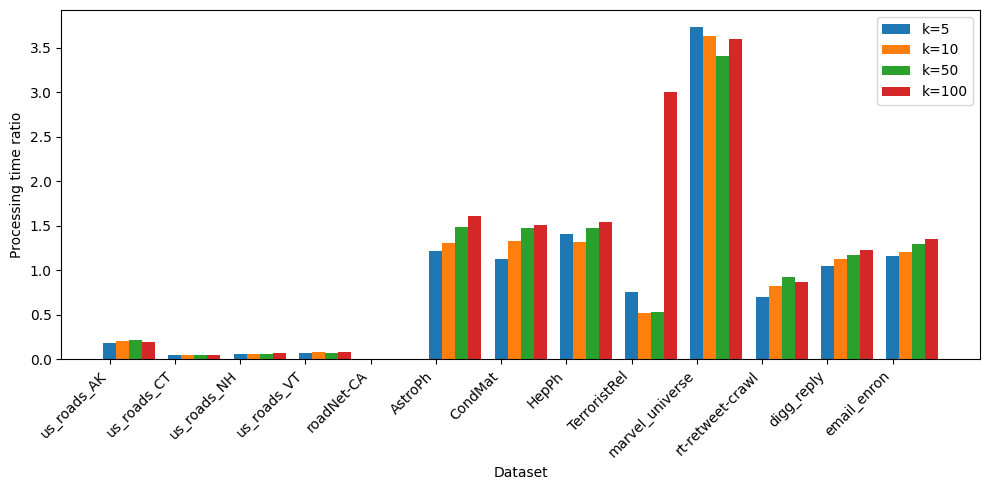

In [257]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

plt.figure(figsize=(10, 5))

for index_k, k in enumerate(ks):
    ratios = [results[dataset]["time_elapsed"]["topkcloseness_1"][str(k)]/results[dataset]["time_elapsed"]["closeness"] for dataset in results.keys()]
    plt.bar(x + (width * index_k), ratios, width, label=f"k={k}")
    
plt.xticks(x, xticklabels, rotation=45, ha="right")
plt.xlabel("Dataset")
plt.ylabel("Processing time ratio")
plt.legend()
plt.tight_layout()

plt.savefig("../images/time_ratios_bar_LB.png")
plt.show()

## Correlation between network metrics and computation time ratio (BFSCUT) across k

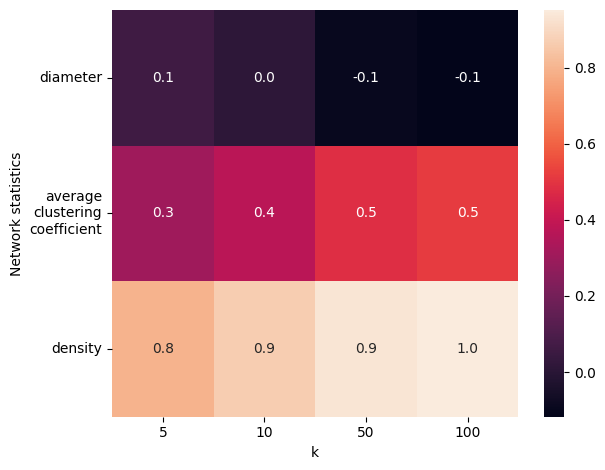

In [260]:
def get_data(variant):
    ks = [5, 10, 50, 100]
    metric_list = ["diameter", "average_clustering_coefficient", "density"]
    data = [[], [], []]

    
    for index_metrics, metric in enumerate(metric_list):
        for index_k, k in enumerate(ks):
            ratios = [results[dataset]["time_elapsed"][variant][str(k)]/results[dataset]["time_elapsed"]["closeness"] for dataset in results.keys()]

            if metric == "diameter":
                metrics = [results[dataset][metric][0] for dataset in results.keys()]

            else:
                metrics = [results[dataset][metric] for dataset in results.keys()]

            data[index_metrics].append(np.corrcoef(metrics, ratios)[0][1])

    data_df = pd.DataFrame(data)
    data_df.columns = ks
    data_df.index = ["diameter", "average\nclustering\ncoefficient", "density"]

    return data_df

sns.heatmap(get_data("topkcloseness_0"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.tight_layout()
plt.savefig("../images/time_ratios_heatmap_BFSCUT.png")
plt.show()

## Correlation between network metrics and computation time ratio (LB) across k

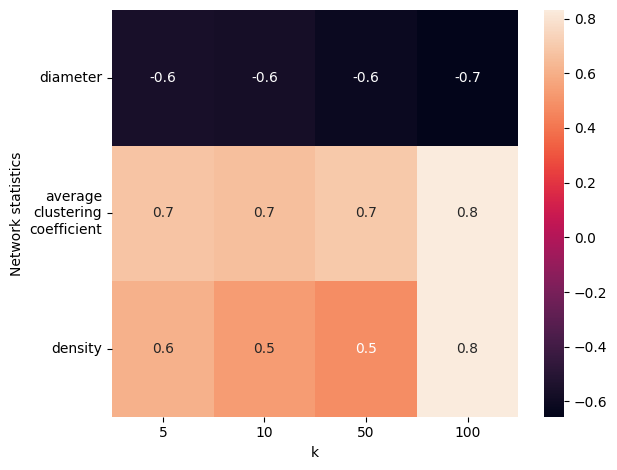

In [261]:
sns.heatmap(get_data("topkcloseness_1"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.tight_layout()
plt.savefig("../images/time_ratios_heatmap_LB.png")
plt.show()

# NDCG score

## nDCG scores of closeness centrality wrt topk closeness BFSCUT and LB

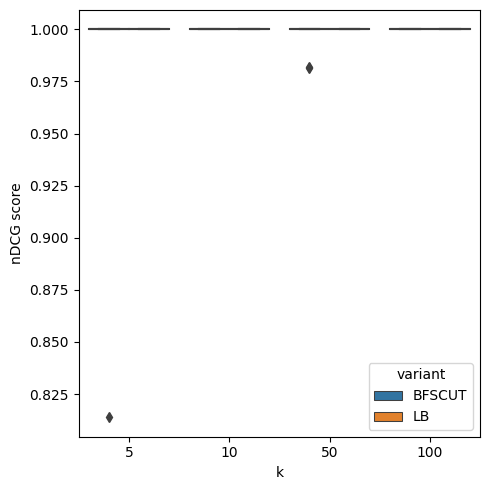

In [262]:
ks = [5, 10, 50, 100]
plt.figure(figsize=(5, 5))

values = []
values_k = []
values_variant = []

for index_k, k in enumerate(ks):
    values += [results[dataset]["ndcg_closeness"][str(k)]["topkcloseness_0"] for dataset in results.keys()]
    values_k += ([str(k)] * len(results.keys()))
    values_variant += (["BFSCUT"] * len(results.keys()))
    
    values += [results[dataset]["ndcg_closeness"][str(k)]["topkcloseness_1"] for dataset in results.keys()]
    values_k += ([str(k)] * len(results.keys()))
    values_variant += (["LB"] * len(results.keys()))
    
sns.boxplot(x="k", y="nDCG score", hue="variant", data=pd.DataFrame({"nDCG score": values, "k": values_k, "variant": values_variant}))

plt.tight_layout()
plt.savefig("../images/nDCG_score_boxplot.png")
plt.show()

## nDCG scores of closeness centrality wrt degree centrality across datasets and k and network statistics

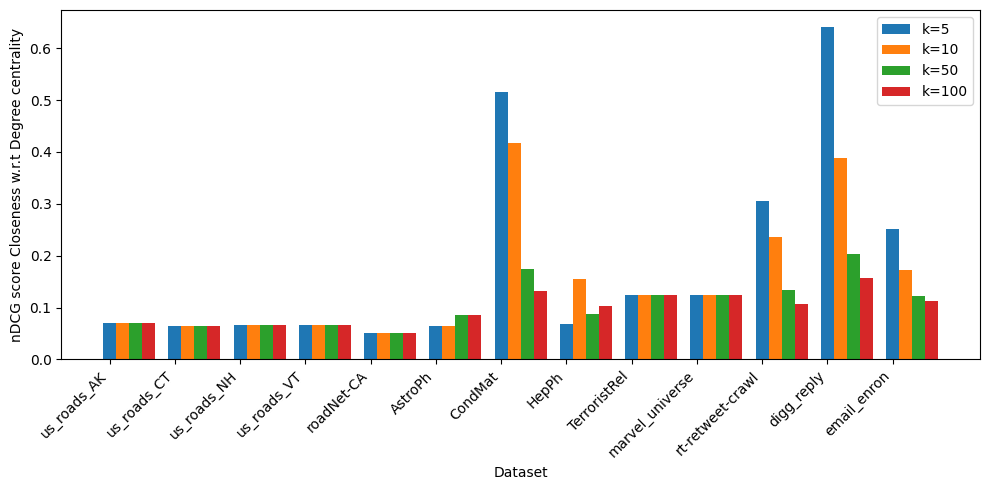

In [263]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

plt.figure(figsize=(10, 5))

for index_k, k in enumerate(ks):
    ndcg_scores = [results[dataset]["ndcg_degree"][str(k)]["closeness"] for dataset in results.keys()]
    plt.bar(x + (width * index_k), ndcg_scores, width, label=f"k={k}")
    
plt.xticks(x, xticklabels, rotation=45, ha="right")
plt.xlabel("Dataset")
plt.ylabel("nDCG score Closeness w.r.t Degree centrality")
plt.legend()

plt.tight_layout()
plt.savefig("../images/nDCG_score_bar.png")
plt.show()

## Correlation between network metrics and nDCG scores of closeness centrality across k

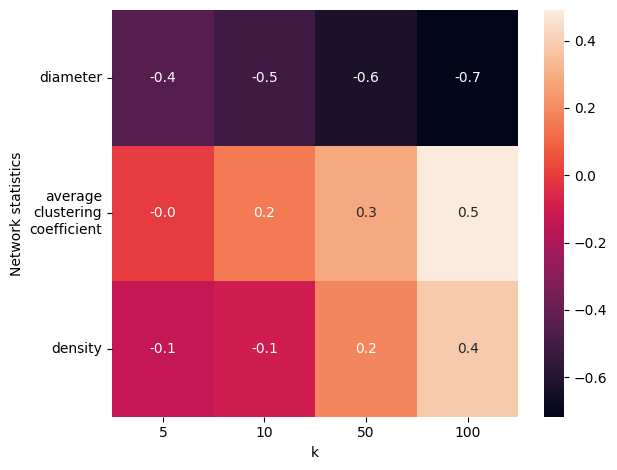

In [264]:
def get_data():
    ks = [5, 10, 50, 100]
    metric_list = ["diameter", "average_clustering_coefficient", "density"]
    data = [[], [], []]

    
    for index_metrics, metric in enumerate(metric_list):
        for index_k, k in enumerate(ks):
            ndcg_scores = [results[dataset]["ndcg_degree"][str(k)]["closeness"] for dataset in results.keys()]

            if metric == "diameter":
                metrics = [results[dataset][metric][0] for dataset in results.keys()]

            else:
                metrics = [results[dataset][metric] for dataset in results.keys()]

            data[index_metrics].append(np.corrcoef(metrics, ndcg_scores)[0][1])

    data_df = pd.DataFrame(data)
    data_df.columns = ks
    data_df.index = ["diameter", "average\nclustering\ncoefficient", "density"]

    return data_df

sns.heatmap(get_data(), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.tight_layout()
plt.savefig("../images/nDCG_score_heatmap.png")
plt.show()

# Kendalltau

## Kendalltau rank correlation of closeness centrality wrt degree centrality across datasets and k

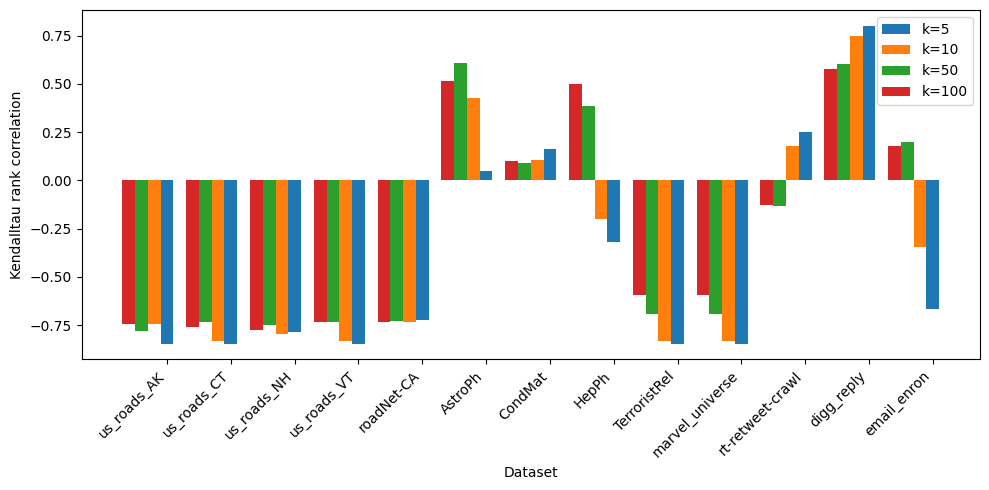

In [265]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

plt.figure(figsize=(10, 5))

for index_k, k in enumerate(ks):
    kendalltau_scores = [results[dataset]["kendalltau"][str(k)]["closeness"] for dataset in results.keys()]
    plt.bar(x - (width * index_k), kendalltau_scores, width, label=f"k={k}")
    
plt.xticks(x, xticklabels, rotation=45, ha="right")
plt.xlabel("Dataset")
plt.ylabel("Kendalltau rank correlation")
plt.legend()

plt.tight_layout()
plt.savefig("../images/kendalltau_rank_correlation_bar_closeness.png")
plt.show()

## Kendalltau rank correlation closeness centrality vs topk closeness BFSCUT and LB across datasets and k=100

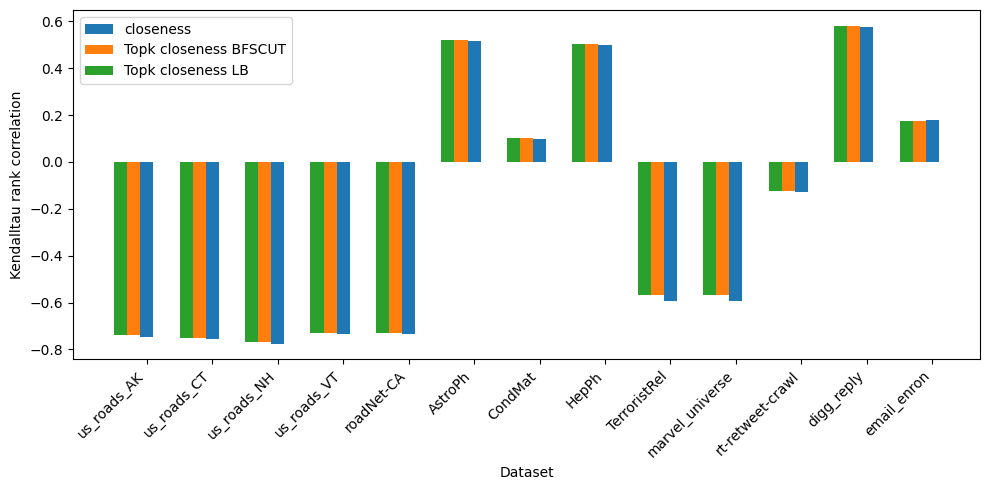

In [266]:
centrality_measures = ["closeness", "topkcloseness_0", "topkcloseness_1"]
labels = ["closeness", "Topk closeness BFSCUT", "Topk closeness LB"]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

plt.figure(figsize=(10, 5))

for index_centrality_measure, (centrality_measure, label) in enumerate(zip(centrality_measures, labels)):
    kendalltau_scores = [results[dataset]["kendalltau"][str(k)][centrality_measure] for dataset in results.keys()]
    plt.bar(x - (width * index_centrality_measure), kendalltau_scores, width, label=label)
    
plt.xticks(x, xticklabels, rotation=45, ha="right")
plt.xlabel("Dataset")
plt.ylabel("Kendalltau rank correlation")
plt.legend()

plt.tight_layout()
plt.savefig("../images/kendalltau_rank_correlation_bar_comparison.png")
plt.show()

## Correlation between network metrics and Kendalltau ranking correlation scores of closeness centrality across k

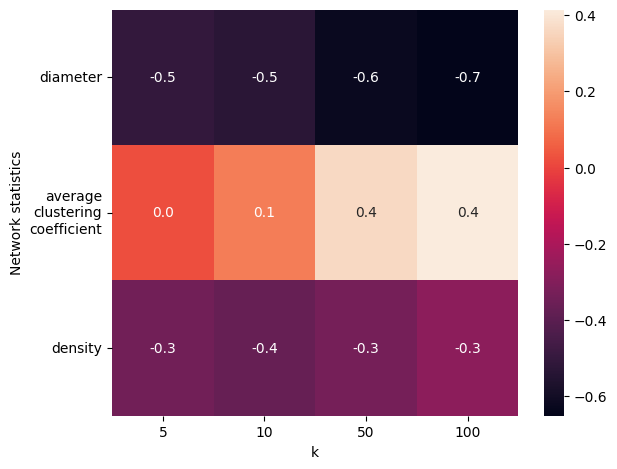

In [268]:
def get_data(variant):
    ks = [5, 10, 50, 100]
    metric_list = ["diameter", "average_clustering_coefficient", "density"]
    data = [[], [], []]

    
    for index_metrics, metric in enumerate(metric_list):
        for index_k, k in enumerate(ks):
            kendalltau_scores = [results[dataset]["kendalltau"][str(k)][variant] for dataset in results.keys()]

            if metric == "diameter":
                metrics = [results[dataset][metric][0] for dataset in results.keys()]

            else:
                metrics = [results[dataset][metric] for dataset in results.keys()]

            data[index_metrics].append(np.corrcoef(metrics, kendalltau_scores)[0][1])

    data_df = pd.DataFrame(data)
    data_df.columns = ks
    data_df.index = ["diameter", "average\nclustering\ncoefficient", "density"]

    return data_df

sns.heatmap(get_data("closeness"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.tight_layout()
plt.savefig("../images/kendalltau_rank_correlation_heatmap_closeness.png")
plt.show()

## Correlation between network metrics and Kendalltau ranking correlation scores of topk closeness BFSCUT centrality across k

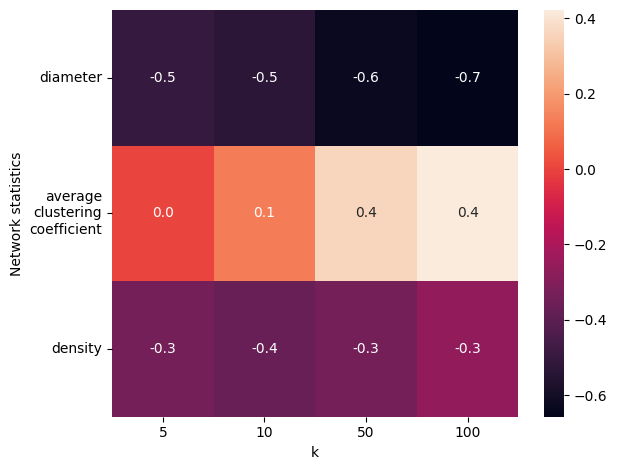

In [269]:
sns.heatmap(get_data("topkcloseness_0"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.tight_layout()
plt.savefig("../images/kendalltau_rank_correlation_heatmap_BFSCUT.png")
plt.show()
plt.show()

## Correlation between network metrics and Kendalltau ranking correlation scores of topk closeness LB centrality across k

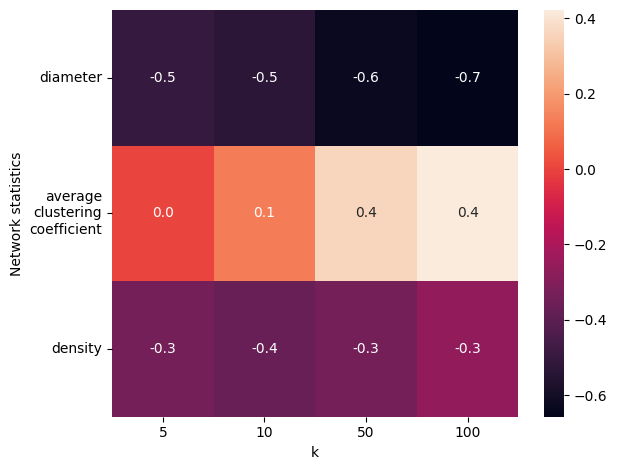

In [270]:
sns.heatmap(get_data("topkcloseness_1"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.tight_layout()
plt.savefig("../images/kendalltau_rank_correlation_heatmap_LB.png")
plt.show()